In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from netCDF4 import Dataset
from sklearn.decomposition import PCA

<br>

**Some key points in clustering:**

1) Points within a cluster are as similar as possible
2) Points belonging to different clusters are as distinct as possible

This means that, in ideal clustering, the *within-cluster* variation is small, and the *between-cluster* variation is large.

A good clustering quality metric should be able to summarize (1) and/or (2) quantitatively. 

One such quality metric is *inertia*. This is calculated as the sum of squared distances between data points and the centers of the clusters they belong to. *Inertia* quantifies the *within-cluster* variation. Inertia is a decreasing function of the number of clusters k. However, its rate of decrease if different above or below the optimal number of clusters $K$. For $k > K$, the inertia decreases rapidly, whereas the decrease if slow for $k > K$. Thus, by plotting the inertia over a range of k, one can determine where the curve bends, or elbows (at $K$).

<br>

<h3 align="left">Read in the data</h3>

In [2]:
def read_netCDF4_data(filename):
    with Dataset(filename) as rootgrp:
        latitude = rootgrp['latitude'][:]
        longitude = rootgrp['longitude'][:]
        level = rootgrp['level'][:]
        time = rootgrp['time'][:]
        specific_humidity = rootgrp['q'][:][:][:][:]
        temperature = rootgrp['t'][:][:][:][:]
    return latitude, longitude, level, time, specific_humidity, temperature

In [3]:
latitude, longitude, level, time, specific_humidity, temperature = read_netCDF4_data("/home/jaminkiukkonen/Downloads/test_data.nc")

In [5]:
temperature.shape

(7, 37, 721, 1440)

In [6]:
latitude.shape

(721,)

<br>

<h3 align="left">K-Means Clustering</h3>

In [7]:
def create_temperature_profiles(t):
    """
    This function creates temperature profiles such that
    each column represent one pressure level.
    For example, the first column has the temperatures associated
    with pressure level 1.
    
    parameters:
        t: a 4D tensor containing time, pressure level, latitude, longitude.
        
    returns:
        2D matrix where each column represents one pressure level.
    """
    i = 0
    T_profiles = np.zeros((t[:, 0, :, :].size, t[0, :, 0, 0].size), float)
    for day in range(0, len(time)):
        print(day)
        for lat in range(0, len(latitude)):
            for lon in range(0, len(longitude)):
                T_profiles[i, :] = t[day, :, lat, lon][None, :]
                i += 1
    return T_profiles

In [8]:
A = create_temperature_profiles(temperature)

0
1
2
3
4
5
6


In [9]:
A.shape

(7267680, 37)

In [10]:
# Find the optimal number of clusters using the elbow method
RSS = []    # The residual sum of squares
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=2)
    km.fit(A)
    RSS.append(km.inertia_)

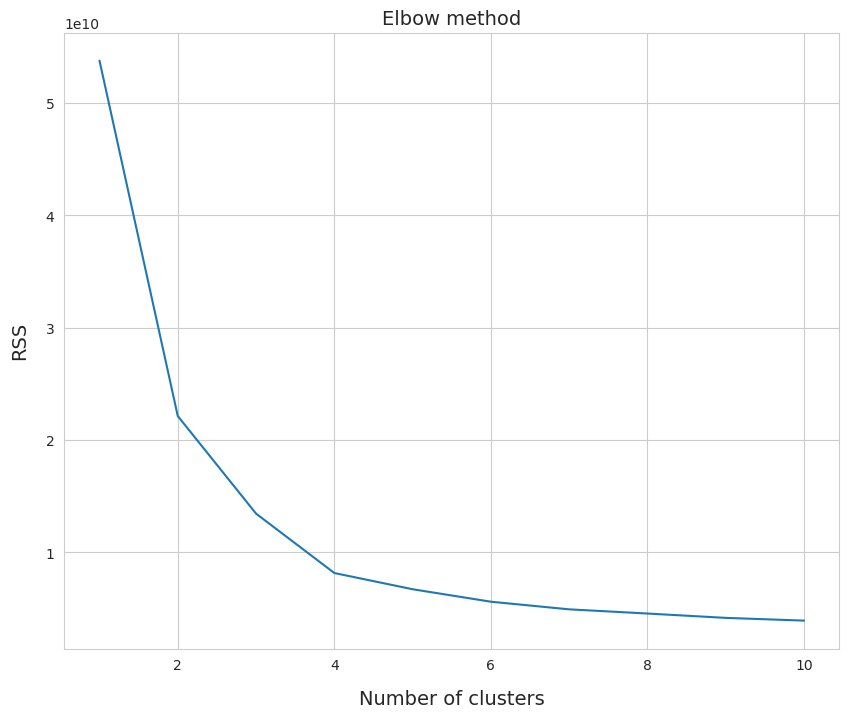

In [11]:
plt.figure(figsize=(10, 8), dpi=100)
sns.set_style('whitegrid')
g = sns.lineplot(x=range(1,11), y=RSS)
g.set_xlabel('Number of clusters', size=14, labelpad=12)
g.set_ylabel('RSS', size=14, labelpad=12)
g.set_title('Elbow method', size=14);

- Based on the elbow method, **4** seems to be the 'best' number of clusters.

In [12]:
model = KMeans(n_clusters=4, random_state=2)
model.fit(A)

KMeans(n_clusters=4, random_state=2)

In [13]:
# The cluster centers
model.cluster_centers_.shape

(4, 37)

In [14]:
pred = model.predict(A)

- Predict the closest cluster each sample in A belongs to.

In [15]:
pred.shape

(7267680,)

In [16]:
temperature[:, 0, :, :].flatten().shape

(7267680,)

- This is the shape of one temperature profile.

In [17]:
np.unique(pred)

array([0, 1, 2, 3], dtype=int32)

- As expected, since n_clusters=4, each of the predictions belongs in one of the four possible clusters.

After finding the clusters using *K-Means*, we can combine it with PCA. Let's try n_components=2 so that we are able to plot it nicely.

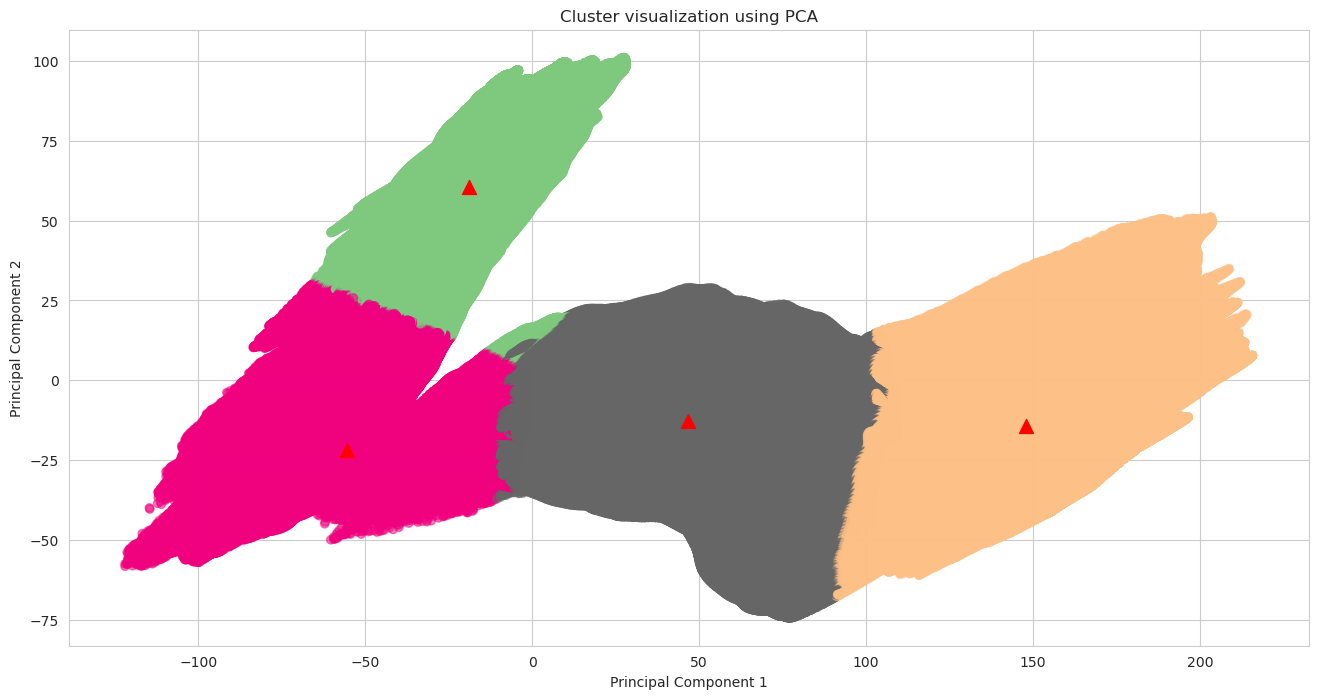

In [18]:
pca = PCA(n_components=2)
A_reduced = pca.fit_transform(A)
pred = model.predict(A)

plt.figure(figsize=(16, 8))
plt.scatter(A_reduced[:, 0], 
            A_reduced[:, 1], 
            c=pred, 
            cmap=cm.Accent, 
            alpha=0.5)
plt.grid(True)

# Plot the cluster centers transformed by PCA
centers_transformed = pca.transform(model.cluster_centers_)
for center in centers_transformed:
    plt.scatter(center[0], center[1], marker='^', c='red', s=100)
    
plt.title('Cluster visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()